# Portland Trail Blazers - RFM Clustering : Individual Buyers
* StelllarAlgo Data Science
* Ryan Kazmerik
* Jul 15, 2022

## Hypothesis

The NBA has provided StellarAlgo with a dataset containing ~400,000 fans who are engaging with the Portland Trail Blazers team through various channels, but are unknown to the team as they have not yet purchased a ticket.

***We estimate that by calculating RFM (recency, frequency, monetary) metrics for known PTB fans, we can approximate the Potential Gross Revenue of the unknown fans.***

This experiment will start with some exploratory data analysis, then calculate and cluster the known fans based on the RFM metrics. Then we'll segment the known fans into three groups and calculate the **Total Gross Revenue** of each group.

The same segmentation is applied to the unknown fans provided by the NBA, allowing us to approximate the **Potential Gross Revenue** for each segment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

#from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from pycaret.clustering import *

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Data Wrangling

For our experiment, we need two datasets:
1. Fans who have bought tickets to a Trail Blazers game. We can get this from our Trail Blazers StellarAlgo tables.
2. Fans who have engaged with the Trail Blazers via streaming, or gaming data. This we can get from our dataset provided by the NBA.

### PTB Ticketing Dataset

In [2]:
"""
    data/ptb_cohort_purchase.csv contains data from the following query:

    SELECT p.dimcustomermasterid, p.purchasedate, p.ticketcount, p.revenue, p.isplanproduct, p.producttype, p.subproductname, p.seasonyear,
       c.dimcustomermasterid, c.country, c.stateprovince, c.zippostal 
    FROM "ptb_cohort_purchase"  p 
    INNER JOIN "ptb_dim_customer_master" c
    ON p.dimcustomermasterid = c.dimcustomermasterid
"""

df = pd.read_csv("./data/ptb_cohort_purchase.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975722 entries, 0 to 1975721
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   dimcustomermasterid  int64  
 1   purchasedate         object 
 2   ticketcount          int64  
 3   revenue              float64
 4   isplanproduct        bool   
 5   producttype          object 
 6   subproductname       object 
 7   seasonyear           int64  
 8   country              object 
 9   stateprovince        object 
 10  zippostal            object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 152.6+ MB


In [3]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,isplanproduct,producttype,subproductname,seasonyear,country,stateprovince,zippostal
0,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016
1,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016
2,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016
3,702748196,2017-02-06,2,302.40,True,Package,Full Season,2017,USA,OR,97123-4016
4,702748196,2017-02-06,2,68.00,True,Package,Full Season,2017,USA,OR,97123-4016


### NBA Engagement Dataset

In [4]:
"""
  data/ptb_nba_engagement.csv contains data from the following query:

  SELECT dimcustomermasterid, entity_source
  FROM "league-nba-poc"."tagged_customer_master";
"""

df2 = pd.read_csv("./data/ptb_nba_engagement.csv")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671077 entries, 0 to 1671076
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   dimcustomermasterid  1671077 non-null  int64 
 1   country_value        1447104 non-null  object
 2   stateprovince_value  936378 non-null   object
 3   zippostal_value      1263889 non-null  object
 4   entity_source        402626 non-null   object
dtypes: int64(1), object(4)
memory usage: 63.7+ MB


## Data Preprocessing

For our analysis we will only consider **non-package buyers**, because we are interested in modelling the typical individual ticket buyer. Let's see how much data we have for NP buyers and what sub-products are included:

In [5]:
df['isplanproduct'].value_counts()

True     1017544
False     958178
Name: isplanproduct, dtype: int64

Remove the rows where isplanproduct = True:

In [6]:
df = df[df['isplanproduct'] == False]
df.drop(columns=["isplanproduct"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958178 entries, 20 to 1975699
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dimcustomermasterid  958178 non-null  int64  
 1   purchasedate         958178 non-null  object 
 2   ticketcount          958178 non-null  int64  
 3   revenue              411459 non-null  float64
 4   producttype          958178 non-null  object 
 5   subproductname       958178 non-null  object 
 6   seasonyear           958178 non-null  int64  
 7   country              936062 non-null  object 
 8   stateprovince        608520 non-null  object 
 9   zippostal            707654 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 80.4+ MB


Let's include data from 2018 to present in our analysis, so we'll remove data from seasons prior to 2018:

In [7]:
df = df[df["seasonyear"] >= 2018]
df.shape

(799757, 10)

We'll also have a look at the included product and subproduct types:

In [8]:
df["producttype"].value_counts()

Individual    691929
Comp           58778
Other          49050
Name: producttype, dtype: int64

In [9]:
df["subproductname"].value_counts()

Individual           691301
Comp                  58012
Group                 31173
Suite                 13225
Deposit                1847
Group Broker           1459
Suite Broker           1345
Comp Broker             766
Individual Broker       628
Deposit Broker            1
Name: subproductname, dtype: int64

Let's remove the broker records so we are looking at actual customer behaviour:

In [10]:
df = df[df["subproductname"].isin(["Individual"])]
df.reset_index(drop=True, inplace=True)

df["subproductname"].value_counts()

Individual    691301
Name: subproductname, dtype: int64

In [11]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear,country,stateprovince,zippostal
0,486156197,2021-10-06,2,61.20,Individual,Individual,2021,USA,OR,97086
1,612548146,2021-10-21,2,276.00,Individual,Individual,2021,US,IL,60069
2,612743431,2019-09-06,4,712.00,Individual,Individual,2019,CA,BC,V5V2K8
3,612750999,2021-12-09,2,110.00,Individual,Individual,2021,US,WA,98270-3559
4,616770053,2021-10-29,4,20.00,Individual,Individual,2021,USA,NaN,97128


## Exploratory Data Analysis (EDA)

Let's have a closer look at the data and decide whether we need any data cleaning and data transformation for further analysis:

In [12]:
# generate a pandas profile report on the ptb dataset
#profile = ProfileReport(df, minimal=True)
#profile.to_file("pandas-profile-report.html")

By reading the profiling report, we can see that the following actions should be taken to improve the dataset quality:
* Remove missing values from revenue (33.3%)
* Remove zero values from revenue (7.4%)

In [13]:
df.dropna(subset=['revenue'], inplace=True)
df['revenue'].isnull().sum()

0

Let's also drop any rows where revenue = 0, and then check the value counts to ensure the zero values are gone:

In [14]:
df = df[df['revenue'] > 0]
df['revenue'].value_counts(bins=[0, 1000, 10000, 100000])

(-0.001, 1000.0]       198888
(1000.0, 10000.0]        4225
(10000.0, 100000.0]        17
Name: revenue, dtype: int64

### Data Types

Let's look at the data types in our dataframe to see if we need to convert any values to a different type

In [15]:
df.dtypes

dimcustomermasterid      int64
purchasedate            object
ticketcount              int64
revenue                float64
producttype             object
subproductname          object
seasonyear               int64
country                 object
stateprovince           object
zippostal               object
dtype: object

Purchase date should be a datetime not an object (string), all of the other inferred data types look correct:

In [16]:
df['purchasedate'] =  pd.to_datetime(df['purchasedate'], format='%Y-%m-%d')

Our cleaned up dataset is ready for the next step, calculating RFM metrics:

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203130 entries, 0 to 691300
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dimcustomermasterid  203130 non-null  int64         
 1   purchasedate         203130 non-null  datetime64[ns]
 2   ticketcount          203130 non-null  int64         
 3   revenue              203130 non-null  float64       
 4   producttype          203130 non-null  object        
 5   subproductname       203130 non-null  object        
 6   seasonyear           203130 non-null  int64         
 7   country              191477 non-null  object        
 8   stateprovince        150470 non-null  object        
 9   zippostal            163306 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 17.0+ MB


In [18]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear,country,stateprovince,zippostal
0,486156197,2021-10-06,2,61.20,Individual,Individual,2021,USA,OR,97086
1,612548146,2021-10-21,2,276.00,Individual,Individual,2021,US,IL,60069
2,612743431,2019-09-06,4,712.00,Individual,Individual,2019,CA,BC,V5V2K8
3,612750999,2021-12-09,2,110.00,Individual,Individual,2021,US,WA,98270-3559
4,616770053,2021-10-29,4,20.00,Individual,Individual,2021,USA,NaN,97128


## Calculating RFM Metrics

**RFM** stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates low revenue.

* Mid Value: In the middle of everything. Often purchasing (but not as much as our High Values), fairly frequent and generates moderate revenue.

* High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

Let's create a dataframe to hold basic information about each individual customer:

In [19]:
# create a generic user dataframe to keep dimcustomermasterid and new segmentation scores
df_customer = df[["dimcustomermasterid", "country", "stateprovince"]]
df_customer = df_customer.drop_duplicates(subset="dimcustomermasterid", keep="first")

### Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score:

In [20]:
# get the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('dimcustomermasterid')["purchasedate"].max().reset_index()
df_max_purchase.columns = ['dimcustomermasterid','maxpurchasedate']

# we take our observation point as the max invoice date in our dataset
df_max_purchase['recency'] = (df_max_purchase['maxpurchasedate'].max() - df_max_purchase['maxpurchasedate']).dt.days

#merge this dataframe to our new user dataframe
df_customer = pd.merge(df_customer, df_max_purchase[['dimcustomermasterid','recency']], on='dimcustomermasterid')

df_customer.head()

,dimcustomermasterid,country,stateprovince,recency
0,486156197,USA,OR,105
1,612548146,US,IL,172
2,612743431,CA,BC,948
3,612750999,US,WA,123
4,616770053,USA,NaN,164


Let's have a look at the standard statistics for the recency metric, specifically the mean, min and max values help us to understand the range of values in this metric:

In [21]:
df_customer["recency"].describe()

count   122337.00
mean       661.08
std        464.53
min          0.00
25%        149.00
50%        820.00
75%       1134.00
max       1406.00
Name: recency, dtype: float64

Let's have a look at the distribution to see if there are any outlier datapoints affecting the range of values:

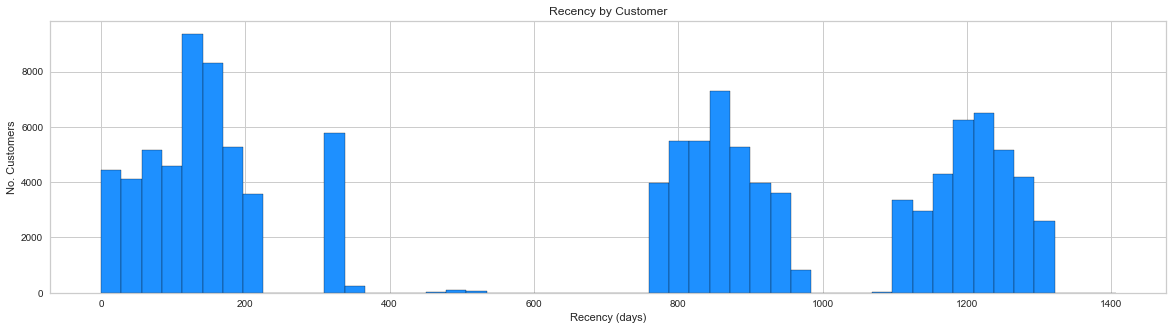

In [22]:
recency_fig = plt.figure(figsize=(20, 5))

plt.hist(df_customer["recency"], bins=50, color="dodgerblue", edgecolor="black")
plt.title("Recency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Recency (days)")

plt.show()


We can observe a large gap in purchasing behaviour between ~800 - 400 days ago, which aligns with when COVID-19 was declared a global pandemic. There's not much we can do to fill in that gap, so we'll leave the data as is.

### Clustering Recency

We are going to apply K-means clustering to assign a recency score. We will use the elbow method to determine how many clusters we need:

In [23]:
df_recency = df_customer[['recency']]
setup(df_recency, silent= True, verbose= False);

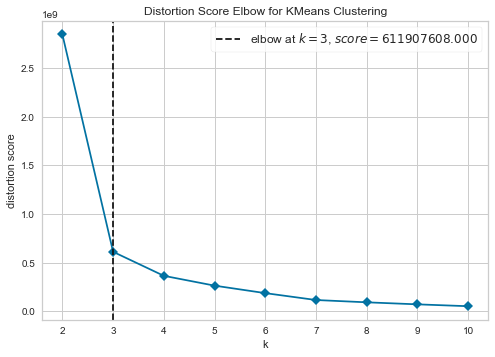

In [24]:
#kmeans = create_model('kmeans')
#plot_model(kmeans, plot = 'elbow')

Here it looks like 3 is the optimal number of clusters as we don't get any increase in learning beyond 3 clusters.

In [25]:
# build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['recency']])
df_customer['recencycluster'] = kmeans.predict(df_customer[['recency']])

#function for ordering clusters from worst to best
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

df_customer = order_cluster('recencycluster', 'recency', df_customer, False)

In [26]:
df_customer.groupby('recencycluster')["recency"].describe()

,count,mean,std,min,25%,50%,75%,max
recencycluster,,,,,,,,
0,35344.00,1210.68,56.62,1096.00,1170.00,1212.00,1254.00,1406.00
1,36065.00,855.96,56.43,502.00,812.00,855.00,895.00,978.00
2,50928.00,141.65,86.81,0.00,76.00,133.00,175.00,497.00


We can see that cluser 0 contains the lower value fans, that have not purchased in a longer period of time compared to the higher value fans in cluster 2 that have purchased between 0 and 497 days ago.

### Frequency

To create frequency clusters, we first need to find total number of purchases for each customer:

In [27]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('dimcustomermasterid')["purchasedate"].count().reset_index()
df_frequency.columns = ['dimcustomermasterid','frequency']

#add this data to our main dataframe
df_customer = pd.merge(df_customer, df_frequency, on="dimcustomermasterid")

In [28]:
df_customer.head()

,dimcustomermasterid,country,stateprovince,recency,recencycluster,frequency
0,486156197,USA,OR,105,2,20
1,612548146,US,IL,172,2,1
2,612750999,US,WA,123,2,1
3,616770053,USA,NaN,164,2,2
4,619838265,US,CA,187,2,1


Let's plot the distribution on frequency to see the range of values:

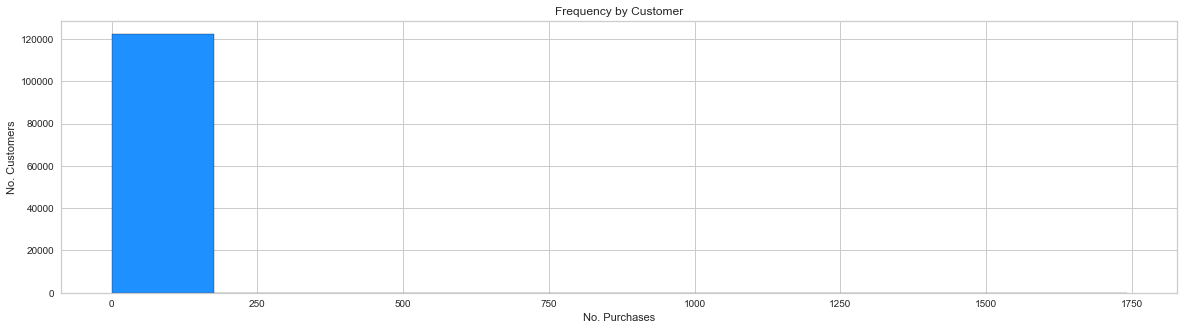

In [29]:
freq_fig = plt.figure(figsize=(20, 5))

plt.hist(df_customer["frequency"], color="dodgerblue", edgecolor="black")
plt.title("Frequency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("No. Purchases")
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

In [30]:
df_customer["frequency"].value_counts(bins=[0, 5, 10, 100, 1000, 5000])

(-0.001, 5.0]       118992
(5.0, 10.0]           2487
(10.0, 100.0]          843
(100.0, 1000.0]         14
(1000.0, 5000.0]         1
Name: frequency, dtype: int64

Most customers have a lower frequency, but a few big purchasers are also present in the data. Because this analysis is focused on the typical individual ticket buyer, let's remove these outliers:

In [31]:
df_customer = df_customer[df_customer["frequency"] <= 10]

Let's observe the standard statistics for the frequency metric now that we have removed the outliers:

In [32]:
df_customer["frequency"].describe()

count   121479.00
mean         1.48
std          1.16
min          1.00
25%          1.00
50%          1.00
75%          1.00
max         10.00
Name: frequency, dtype: float64

We could experiment with limiting frequency even further to < 5 games, but let's leave the limit at 10 games for now.

### Clustering Frequency

Let's apply the same k-means clustering with 3 clusters to assign a frequency cluster to each fan:

In [33]:
# build 3 clusters for frequency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['frequency']])
df_customer['frequencycluster'] = kmeans.predict(df_customer[['frequency']])

df_customer = order_cluster('frequencycluster', 'frequency', df_customer, True)

In [34]:
df_customer.groupby('frequencycluster')["frequency"].describe()

,count,mean,std,min,25%,50%,75%,max
frequencycluster,,,,,,,,
0,91502.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
1,25996.00,2.42,0.66,2.00,2.00,2.00,3.00,4.00
2,3981.00,6.44,1.54,5.00,5.00,6.00,7.00,10.00


Again, we see the lower value fans in cluster 0 that have only purchased for 1 event, compared to the higher value fans in cluster 2 who purchase on average 5.4 events.

### Revenue

Let’s add revenue to our dataset and cluster based on revenue:

In [35]:
df_revenue = df.groupby("dimcustomermasterid")["revenue"].sum().reset_index()

df_customer = pd.merge(df_customer, df_revenue, on="dimcustomermasterid")

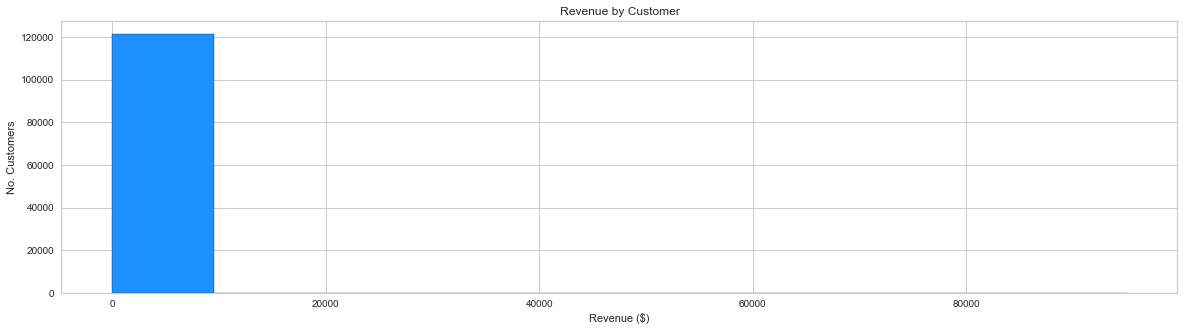

In [36]:
revenue_fig = plt.figure(figsize=(20, 5))

plt.hist(df_customer["revenue"], color="dodgerblue", edgecolor="black")
plt.title("Revenue by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Revenue ($)")
plt.rcParams["figure.figsize"] = (20,4) 

plt.show()

In [37]:
df_customer["revenue"].value_counts(bins=[0, 50, 100, 500, 1000, 5000, 10000])

(100.0, 500.0]       64412
(50.0, 100.0]        20217
(-0.001, 50.0]       17315
(500.0, 1000.0]      13260
(1000.0, 5000.0]      6089
(5000.0, 10000.0]      147
Name: revenue, dtype: int64

Again, a few big spenders are present in the dataset. Let's remove the outlier customers who spend generate significantly more revenue than most:

In [38]:
df_customer = df_customer[df_customer["revenue"] <= 5000]

In [39]:
df_customer["revenue"].describe()

count   121293.00
mean       303.31
std        408.68
min          1.00
25%         80.28
50%        176.00
75%        357.02
max       5000.00
Name: revenue, dtype: float64

These stats look reasonable, the min of $1 revenue may need some more investigation, but we can proceed with clustering the revenue for now.

### Clustering Revenue

Let's apply the same k-means clustering with 3 clusters to assign a revenue cluster to each fan:

In [40]:
# build 3 clusters for revenue and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['revenue']])
df_customer['revenuecluster'] = kmeans.predict(df_customer[['revenue']])

df_customer = order_cluster('revenuecluster', 'revenue', df_customer, True)

In [41]:
df_customer.groupby("revenuecluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
revenuecluster,,,,,,,,
0,100605.00,167.46,119.64,1.00,68.00,136.00,245.32,477.15
1,18388.00,785.73,273.28,477.20,565.00,698.00,938.00,1588.89
2,2300.00,2389.13,752.67,1589.60,1807.94,2131.37,2748.96,5000.00


Once again, the clusters are ordered from low-high value with cluster 0 averaging ~$150 in revenue compared to ~$2000 in cluster 2.

### Engagement

Let's add a flag to show whether the fan has engaged with the team via purchasing a streaming subscription, or video game engagement provided by via the NBA dataset:

In [42]:

# merge the NBA dataset with our customer dataset
df_customer = pd.merge(df_customer, df2, on="dimcustomermasterid")

# create a flag based on the source of the record
df_customer["is_engaged"] = np.where(df_customer["entity_source"] == "PTB", 1, 0)
df_customer["is_engaged"].value_counts()


0    118122
1      3171
Name: is_engaged, dtype: int64

Because this metric is binary (either 0 or 1) we don't need to cluster this metric.

### Overall Score

We have scores (cluster numbers) for recency, frequency & revenue, and our engagement score. Let’s create an overall score out of them:

In [43]:
# calculate overall score and use mean() to see details
df_customer["score"] = df_customer["recencycluster"]+df_customer["frequencycluster"]+df_customer["revenuecluster"]+df_customer["is_engaged"]+1

df_customer.groupby("score").agg({
    "recency": "mean",
    "frequency": "mean",
    "revenue": "mean",
    "is_engaged": "mean"
})

,recency,frequency,revenue,is_engaged
score,,,,
1,1211.84,1.00,151.54,0.00
2,931.34,1.12,219.69,0.02
3,328.28,1.21,231.49,0.02
4,289.34,2.13,453.78,0.06
5,239.56,3.23,836.35,0.09
6,207.97,5.28,1295.76,0.15
7,182.89,6.79,2243.18,0.22
8,158.56,7.18,2547.61,1.00


As we can see, the higher the score, the higher value a fan (more recent purchase, higher frequency, higher revenue, more engagement). Let's plot each score group to see the distribution of fans across the revenue spectrum:

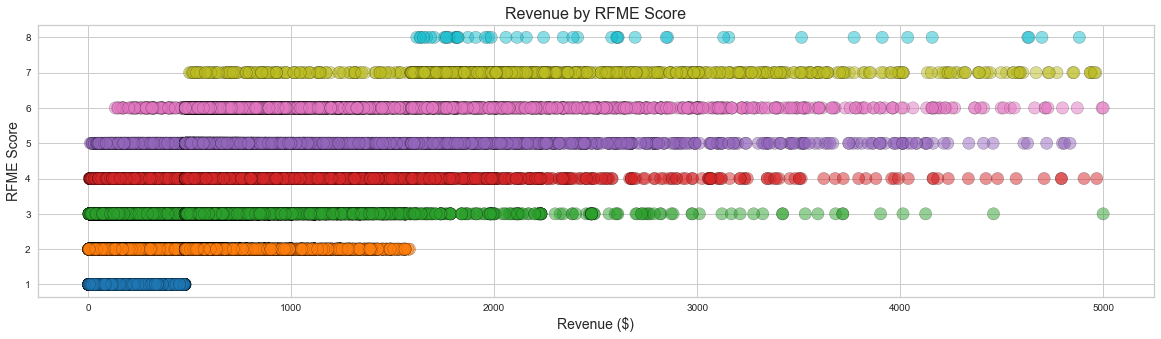

In [51]:
colors = {1:'tab:blue', 2:'tab:orange', 3:'tab:green', 4:'tab:red', 5:'tab:purple', 6:'tab:pink', 7:'tab:olive', 8:'tab:cyan'}

cluster_fig = plt.figure(figsize=(20, 5))

plt.scatter(df_customer["revenue"], df_customer["score"], c=df_customer["score"].map(colors), edgecolors="black", s=150, alpha=.5)
plt.title("Revenue by RFME Score", fontsize=16)
plt.ylabel("RFME Score", fontsize=14)
plt.xlabel("Revenue ($)", fontsize=14)
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

## Segmentation

Let's add a segment to each customer in our dataset:

In [45]:
# populate a segment column based on conditions
conditions  = [
    df_customer["country"].isin(["US","USA","Uni"]) & ~df_customer["stateprovince"].isin(["OR","WA","Orego","OREGO","Washi","WASHI"]), 
    df_customer["country"].isin(["US","USA","Uni"]) & df_customer["stateprovince"].isin(["OR","WA","Orego","OREGO","Washi","WASHI"]), 
    ~df_customer["country"].isin(["US","USA","Uni"]) & ~df_customer["stateprovince"].isin(["OR","WA","Orego","OREGO","Washi","WASHI"])
]

choices = ["Out-of-Market US", "In-Market US", "International"]
    
df_customer["segment"] = np.select(conditions, choices, default="In-Market US")

df_customer["segment"].value_counts()

In-Market US        68678
Out-of-Market US    38870
International       13745
Name: segment, dtype: int64

In [46]:
df_customer.head()

,dimcustomermasterid,country,stateprovince,recency,recencycluster,frequency,frequencycluster,revenue,revenuecluster,country_value,stateprovince_value,zippostal_value,entity_source,is_engaged,score,segment
0,612548146,US,IL,172,2,1,0,276.00,0,US,IL,60069,NaN,0,3,Out-of-Market US
1,612750999,US,WA,123,2,1,0,110.00,0,US,WA,98270-3559,NaN,0,3,In-Market US
2,619838265,US,CA,187,2,1,0,351.00,0,US,CA,95233,NaN,0,3,Out-of-Market US
3,376854573,US,OR,168,2,1,0,176.00,0,US,OR,97206,NaN,0,3,In-Market US
4,472439529,USA,OR,66,2,1,0,76.00,0,USA,OR,97006,NaN,0,3,In-Market US


### Calculating TGR (Total Gross Revenue)

Let's use our RFME scores to calculate a Total Gross Revenue for each segment:

In [47]:
# calculate metrics used for tgr calc
df_tgr = df_customer.groupby(["segment", "score"]).agg(
    {
        "revenue": ["mean","sum"],
        "segment": ["count"]
    })

df_tgr.columns = ['revenue_avg', 'revenue_sum', 'fan_count']
df_tgr = df_tgr.reset_index()

df_tgr

,segment,score,revenue_avg,revenue_sum,fan_count
0,In-Market US,1,153.08,1793135.96,11714
1,In-Market US,2,202.86,3535996.91,17431
2,In-Market US,3,238.01,5277173.95,22172
3,In-Market US,4,449.86,4611960.47,10252
4,In-Market US,5,826.75,3748493.78,4534
5,In-Market US,6,1271.20,2427986.87,1910
6,In-Market US,7,2241.85,1398916.64,624
7,In-Market US,8,2617.87,107332.76,41
8,International,1,129.67,413770.07,3191
9,International,2,188.84,695676.62,3684


<Figure size 1440x360 with 0 Axes>

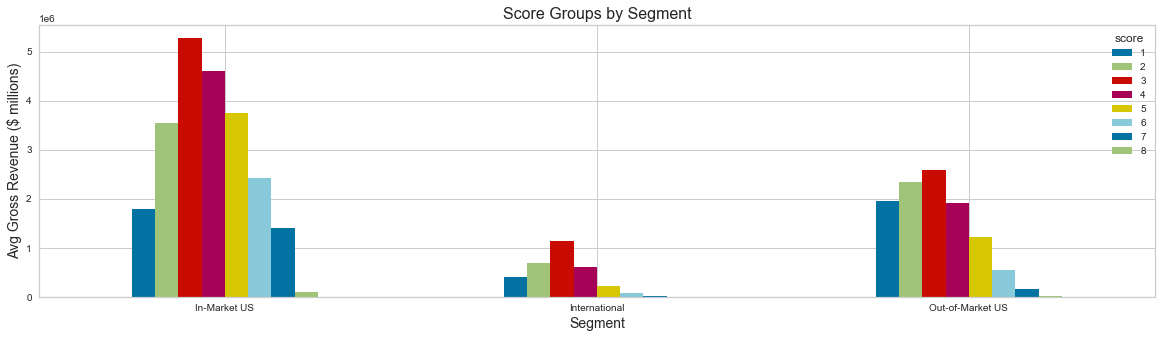

In [54]:
segment_fig = plt.figure(figsize=(20, 5))

df_tgr.pivot("segment", "score", "revenue_sum").plot(kind='bar')
plt.title("Score Groups by Segment", fontsize=16)
plt.xlabel("Segment", fontsize=14)
plt.xticks(rotation = 0)
plt.ylabel("Avg Gross Revenue ($ millions)", fontsize=14)

plt.show()

Observations:
* The In-Market US segment generates the most revenue by a large margin
* Both US markets contain fans from all score groups (low value to high value)
* The International segment does not contain any very high value fans (RFME Score=8), and a very small amount of RFME=7 fans
* For In-Market US, the highest RMFE Score fans generate the least amount of total revenue (less than RFME=1)

We can also calculate the TGR for each overall segment:

In [49]:
tgr_aggs = df_customer.groupby("segment").agg({
    "revenue": "sum",
    "segment": "count"
})
tgr_aggs.columns = ["total_gross_revenue", "fan_count"]

tgr_aggs.head()

,total_gross_revenue,fan_count
segment,,
In-Market US,22900997.34,68678
International,3159290.60,13745
Out-of-Market US,10729694.69,38870


In [50]:
in_market_tgr_per_fan = tgr_aggs.iloc[0]["total_gross_revenue"] / tgr_aggs.iloc[0]["fan_count"]
international_tgr_per_fan = tgr_aggs.iloc[1]["total_gross_revenue"] / tgr_aggs.iloc[1]["fan_count"]
out_market_tgr_per_fan = tgr_aggs.iloc[2]["total_gross_revenue"] / tgr_aggs.iloc[2]["fan_count"]

print(f"IN-MARKET US TGR / FAN: {round(in_market_tgr_per_fan, 2)}")
print(f"OUT-OF-MARKET US TGR / FAN: {round(out_market_tgr_per_fan, 2)}")
print(f"INTERNATIONAL TGR / FAN: {round(international_tgr_per_fan, 2)}")

IN-MARKET US TGR / FAN: 333.45
OUT-OF-MARKET US TGR / FAN: 276.04
INTERNATIONAL TGR / FAN: 229.85


## Projections

Now that we have our segments and clusters, let's apply the same analysis to all fans in the NBA dataset and make some projections for **Potential Gross Revenue**.

We'll create a new df for the nba customer and select only fans from the nba data asset:

In [55]:
# select nba fans only from the df2 dataframe
df_nba_fans = df2[df2["entity_source"] == "NBA"]

# create a generic user dataframe to keep dimcustomermasterid and new segmentation scores
df_nba_customer = pd.DataFrame(df_nba_fans["dimcustomermasterid"].unique())
df_nba_customer.columns = ['dimcustomermasterid']

# merge nba customer df back with df2 to get country and state columns
df_nba_customer = pd.merge(df_nba_customer, df2[["dimcustomermasterid", "country_value", "stateprovince_value", "zippostal_value"]], on="dimcustomermasterid")
df_nba_customer.columns = ["dimcustomermasterid", "country", "stateprovince", "zippostal"]

df_nba_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393277 entries, 0 to 393276
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dimcustomermasterid  393277 non-null  int64 
 1   country              295088 non-null  object
 2   stateprovince        15822 non-null   object
 3   zippostal            188291 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.0+ MB


Now we can add a new segment column based on the customers location:

In [56]:
(df_nba_customer["zippostal"].str.startswith("97")==1).value_counts()

False    388012
True       5265
Name: zippostal, dtype: int64

In [57]:
# populate a segment column based on conditions
conditions  = [
    df_nba_customer["zippostal"].str.startswith("97")==1,
    df_nba_customer["zippostal"].str.startswith("98")==1, 
    df_nba_customer["country"].isin(["US","USA","Uni","United States"]),
    ~df_nba_customer["country"].isin(["US","USA","Uni", "United States"])
]

choices = ["In-Market US", "In-Market US", "Out-of-Market US", "International"]
    
df_nba_customer["segment"] = np.select(conditions, choices, default="In-Market US")

df_nba_customer["segment"].value_counts()

International       234385
Out-of-Market US    149933
In-Market US          8959
Name: segment, dtype: int64

In [58]:
international_gpr = round(df_nba_customer["segment"].value_counts().iloc[0] * international_tgr_per_fan, 2)
out_market_gpr = round(df_nba_customer["segment"].value_counts().iloc[0] * out_market_tgr_per_fan, 2)
in_market_gpr = round(df_nba_customer["segment"].value_counts().iloc[0] * in_market_tgr_per_fan, 2)

print(f"INTERNATIONAL GPR: ${round(international_gpr, 2):,}")
print(f"OUT-OF-MARKET US GPR: ${round(out_market_gpr, 2):,}")
print(f"IN-MARKET US GPR: ${round(in_market_gpr, 2):,}")

INTERNATIONAL GPR: $53,873,432.32
OUT-OF-MARKET US GPR: $64,699,755.34
IN-MARKET US GPR: $78,156,764.34


## TODO:
* calculate silhouette score for clusters
* change clustering to Pycaret
* investiage event buyers > 100
* remove dollar tickets
    